Notebook to convert to q-space image data contained into a `.h5` file with spec parameters appended to it, and subsequently plot it with Mayavi.

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from id01lib import id01h5
from id01lib.xrd.qconversion import scan_to_qspace_h5,qconvert_mgrid
from id01lib.xrd.geometries import ID01psic
from mayavi import mlab

%gui qt5

/users/zatterin/Envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Define some convenience functions for the mayavi plotting. Note the 

In [3]:
def mlab_axes_tweak(axes):
    
    # Tweak the appearance of the axes labels in a mayavi plot.
    axes.property.line_width = 2
    
    axes.label_text_property.font_family = 'arial'
    axes.label_text_property.orientation = 0
    axes.label_text_property.italic = False
    axes.label_text_property.bold = False

    axes.title_text_property.font_family = 'arial'
    
    axes.axes.font_factor = 1
    axes.axes.label_format = '%2.2f'
    axes.axes.corner_offset = 0.02


def plone(s, fig, imin, imax, xshift=0.05, yshift=0.05, zshift=0.05, t=1e-6, projections=True, op=1, transp=True):
    
    """
    s: tuple of gridded arrays (qx,qy,qz,i)
    fig: mlab.figure() instance
    imin, imax: minimum and maximum of the colorscale for the isosurface plot
    shifts: how far away the projections are from the isosurface
    t: the threshold level for the projections, everything < t is not plotted.
    op: opacity of the isosurface
    transp: transparency of the isosurface
    """

    # make the projections
    x,y,z = s[3].sum(0), s[3].sum(1), s[3].sum(2)

    # clear the last fig
    mlab.clf(fig)

    # Source the 3D data
    surf = mlab.pipeline.scalar_field(*s, figure=fig)

    # Plot it 
    mlab.pipeline.iso_surface(surf, contours=20, opacity=op, transparent=transp, vmin=imin, vmax=imax)

    if projections:
        # Source the projections
        proj = []
        for img in (x,y,z):
            im = mlab.pipeline.array2d_source(img, figure=fig)
            proj.append(im)

        # Tweak spacing and origin
        origin = surf.origin
        spacing = surf.spacing

        for p in proj: 
            p.origin = origin
        proj[0].spacing = spacing[1], spacing[2], spacing[0]
        proj[1].spacing = spacing[0], spacing[2], spacing[1]
        proj[2].spacing = spacing[0], spacing[1], spacing[2]

        # Threshold them and make the surfaces
        psurf = []
        for p, i in zip(proj, (x,y,z)):
            tresh = mlab.pipeline.threshold(p, low=i.min()+t)
            stresh = mlab.pipeline.surface(tresh)
            stresh.enable_contours = True
            stresh.contour.number_of_contours = 30
            stresh.contour.filled_contours = True
            psurf.append(stresh)

        # Tweak position of projection
        psurf[0].actor.actor.origin = origin
        psurf[1].actor.actor.origin = origin
        psurf[2].actor.actor.origin = origin

        psurf[0].actor.actor.position = [0-xshift,0,0]
        psurf[1].actor.actor.position = [0,0-yshift,0]
        psurf[2].actor.actor.position = [0,0,0-zshift]

        # Tweak orientation of projection
        psurf[1].actor.actor.orientation = [90,0,0]
        psurf[0].actor.actor.orientation = [90,90,0]

    # Tweak the axes
    qx, qy, qz = s[0][:,0,0], s[1][0,:,0], s[2][0,0,:]

    axes = mlab.axes(surf, extent=[qx.min()-xshift, qx.max(), 
                                   qy.min()-yshift, qy.max(), 
                                   qz.min()-zshift, qz.max()],nb_labels=3)

    mlab.outline(extent=[qx.min()-xshift, qx.max(), 
                         qy.min()-yshift, qy.max(), 
                         qz.min()-zshift, qz.max()])
    # Tweak the axes appearance
    mlab_axes_tweak(axes)
    
    # Use the parallel projection
    fig.scene.parallel_projection = True
    
    # This stuff does not seem to have any effect, 
    # but it's supposed to make the rendering nicer
    fig.scene.line_smoothing = True
    fig.scene.render_window.point_smoothing = True
    fig.scene.render_window.line_smoothing = True
    fig.scene.render_window.polygon_smoothing = True
    fig.scene.render_window.multi_samples = 8 # Try with 4 if you think this is slow

    # Tweak the view
    mlab.view(azimuth=59)
    fig.scene.reset_zoom()
    # mlab.colorbar()
    
    return fig

Define a function for quick q-conversion from a given data file, supposetly with the same parameters (`cen_pix`, `det_distance`), so that different scans and bin sizes can be used for the plotting. Note that the data file, sample, and offsets for q-conversion need to be specified at this point, within the functon.

In [4]:
def qconvert(scan_no, nbins, cen_pix=[336.10, 238.65], det_distance=0.411):

    # Sample and scans
    fname = '/users/zatterin/Documents/beam/20180407_HC3505/20180412_HC3505_e17089.h5'
    sample = 'e17089'

    # Experimental parameters
    nrj=8
    print('sample: {0}'.format(sample))
    print('WARNING: cen_pix={0}, det_distance={1}'.format(cen_pix, det_distance))

    # Open the h5 file
    with h5py.File(fname) as h5f:

        # read / set offsets
        scan = h5f['/{0}/{1}.1'.format(sample,scan_no)]
        phi_off = h5f['/{0}/{1}.1/instrument/positioners/phi'.format(sample,scan_no)].value
        rhx_off = h5f['/{0}/{1}.1/instrument/positioners/rhx'.format(sample,scan_no)].value
        rhy_off = h5f['/{0}/{1}.1/instrument/positioners/rhy'.format(sample,scan_no)].value
        nu_off =  h5f['/{0}/{1}.1/instrument/positioners/nu'.format(sample,scan_no)].value
        ID01psic().usemotors = set(('eta', 'phi', 'nu', 'delta'))

        # set to corresponding offsets if needed
#         ID01psic().set_offsets(eta=-4.1001, rhy=0.065, rhx=0, phi=0.809+phi_off, nu=0)
        ID01psic().set_offsets(eta=0, rhy=0, rhx=0, phi=0, nu=0.)


        # convert to q space
        qx, qy, qz, gint = scan_to_qspace_h5(scan, 
                                             cen_pix=(cen_pix[1],cen_pix[0]), 
                                             distance=det_distance, 
                                             energy=8,
                                             nbins=nbins)
        
        return qx, qy, qz, gint

# One peak
Plot one RSM. The next is the crucial step:
* use `mlab.init_notebook()` if you want the rendering to occur in the notebook;
    * `mlab.init_notebook(backend='png')` creates as static png image;
    * `mlab.init_notebook(backend='xrd')` embeds an `html` interactive plot rendered with [x3dom](https://www.x3dom.org/). Does not work with transparent isosurfaces at the moment, see [this](https://github.com/enthought/mayavi/issues/633) 
* do not use it if you want to open an external window with the plot. use `mlab.options.backend=simple` for a single plot window, `mlab.options.backend=envisage` for the full `mayavi2` application GUI.

In [11]:
mlab.init_notebook(backend='png')
mlab.options.backend = 'simple'

Notebook initialized with png backend.


In [11]:
scan = 

# the q-conversion
qx, qy, qz, gint = qconvert(scan, (100,100,100))

# grid the data and use maplog function
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 4.7)
s = (qxx, qyy, qzz, i)

sample: e16014
Selected /e16014/42.1
Offsets used: nu = 0.0, delta = 0.0, rhy = 0.0, rhx = 0.0, phi = 0.0, eta = 1.013, mu = 0.0, rhz = 0.0, 
Max. number of bins: 529, 514, 515
Using binning: (100, 100, 100)

Gridding with bins: (100, 100, 100)


In [12]:
i.min(), i.max()

(1.1447305955682856, 5.844730595568286)


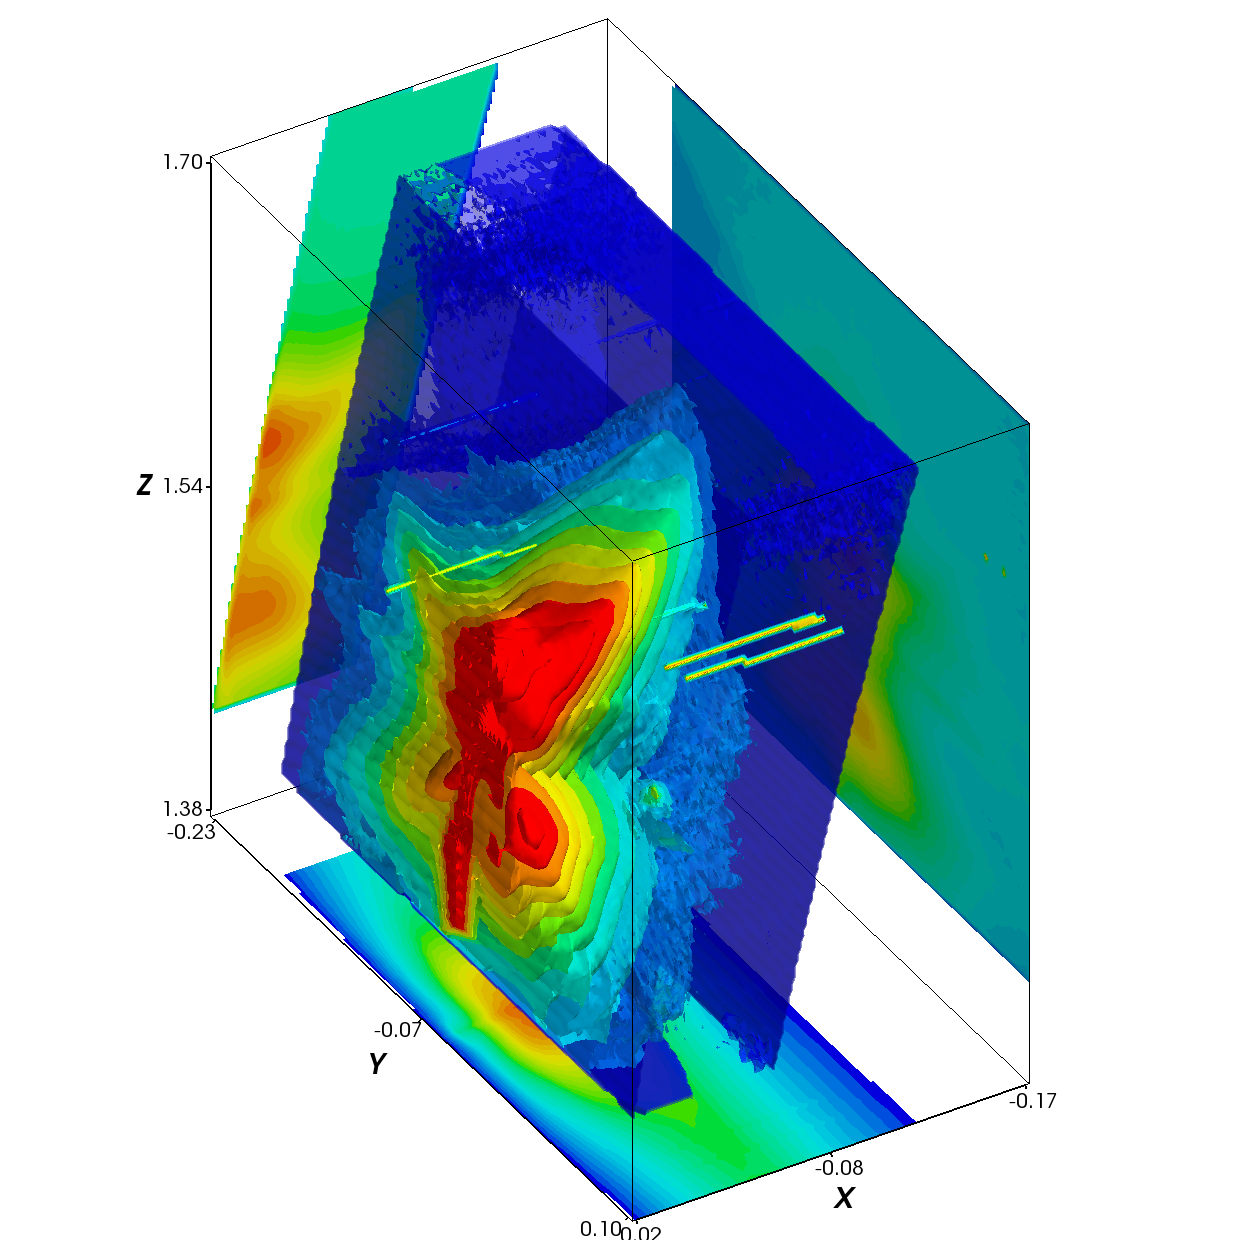

In [14]:
fig = mlab.figure(size=(1240,1240),fgcolor=(0,0,0),bgcolor=(1,1,1))
plone(s, fig, 2, 4)

In [8]:
# save the figure if you like
# fig.scene.save_gl2ps('113.pdf')